In [ ]:
import cv2
import numpy as np
from tqdm import tqdm
import imageio

In [ ]:
# construct high-resolution 1920x1080 perturbation by repeating low-resolution 256x256 perturbation
universal_p = cv2.imread('uap_mdtvsfa.png')
universal_p = cv2.cvtColor(universal_p, cv2.COLOR_BGR2RGB).astype('float32')
universal_p /= 255.
universal_p -= 0.5
universal_perturbation = np.zeros((1080, 1920, 3))
i = 0
j = 0
bs = 256
while (bs*(i+1) < 1080):
  j = 0
  while (bs*(j+1) < 1920):
    universal_perturbation[i*bs:bs*(i+1),j*bs:bs*(j+1)] = universal_p
    j += 1
  i += 1
# the more eps, the more visual distortions
eps = 0.08
universal_perturbation[universal_perturbation>eps] = eps
universal_perturbation[universal_perturbation<-eps] = -eps

In [ ]:
videos = ['pedestrian_area', 'park', 'station', 'dinner', 'blue_hair', 'old_town_cross', 'aspen']

In [ ]:
for vid in videos:
  print(vid)
  cap = cv2.VideoCapture('/videos/'+vid+'.y4m')
  for i in tqdm(range(75)):
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB).astype('float32')
    frame /= 255.
    res = (frame + universal_add)
    res[res < 0] = 0
    res[res > 1] = 1.
    res = (res * 255).astype('uint8')
    imageio.imwrite('/universal_mdtvsfa/'+vid+f'/pic{i:03}.png', res)

pedestrian_area


100%|██████████| 75/75 [01:52<00:00,  1.50s/it]


park


100%|██████████| 75/75 [01:02<00:00,  1.20it/s]


station


100%|██████████| 75/75 [01:38<00:00,  1.32s/it]


dinner


100%|██████████| 75/75 [02:39<00:00,  2.12s/it]


blue_hair


100%|██████████| 75/75 [03:22<00:00,  2.70s/it]


old_town_cross


100%|██████████| 75/75 [01:06<00:00,  1.13it/s]


aspen


100%|██████████| 75/75 [02:11<00:00,  1.75s/it]


In [ ]:
videos = ['aspen', 'blue_hair', 'old_town_cross', 'park', 'pedestrian_area', 'station', 'dinner']
bits = ['1M', '5M', '12M']

In [ ]:
import os
import subprocess 

In [ ]:
for vid in videos:
  print(vid)
  for b in bits:
    os.chdir('/universal_mdtvsfa/'+vid)
    subprocess.run(['ffmpeg', '-r', '25', '-f', 'image2', '-s', '1920x1080', '-i',
            'pic%03d.png', '-c:v', 'libx264', '-b', b, '-pix_fmt', 'yuv420p', 'preproc_'+b+'.mp4'])

aspen
blue_hair
old_town_cross
park
pedestrian_area
station
dinner


In [ ]:
from skimage.metrics import peak_signal_noise_ratio

In [ ]:
bits = ['1M', '5M', '12M']
for vid in videos:
  psnr_with_preprocessing = []
  print(vid)
  for bit in bits:
    cap_gt = cv2.VideoCapture('/videos/'+vid+'.y4m')
    cap_with = cv2.VideoCapture('/universal_mdtvsfa/'+vid+'/preproc_'+bit+'.mp4')
    psnr_with = []
    for i in tqdm(range(75)):
      ret, frame_gt = cap_gt.read()
      ret, frame_with = cap_with.read()
      frame_gt = cv2.cvtColor(frame_gt, cv2.COLOR_BGR2RGB)
      frame_with = cv2.cvtColor(frame_with, cv2.COLOR_BGR2RGB)
      psnr_with.append(peak_signal_noise_ratio(frame_gt, frame_with))
    psnr_with_preprocessing.append(np.array(psnr_with).mean())
  np.save('/universal_mdtvsfa/'+vid+'/psnr.npy', np.array(psnr_with_preprocessing))

aspen


100%|██████████| 75/75 [00:05<00:00, 13.25it/s]


blue_hair


100%|██████████| 75/75 [00:05<00:00, 13.69it/s]


old_town_cross


100%|██████████| 75/75 [00:05<00:00, 13.48it/s]


park


100%|██████████| 75/75 [00:05<00:00, 13.18it/s]


pedestrian_area


100%|██████████| 75/75 [00:05<00:00, 13.62it/s]


station


100%|██████████| 75/75 [00:05<00:00, 13.59it/s]


dinner


100%|██████████| 75/75 [00:05<00:00, 13.67it/s]


### mdtvsfa https://github.com/lidq92/MDTVSFA

In [ ]:
!pip install sk-video

     |████████████████████████████████| 2.3 MB 12.4 MB/s 


In [ ]:
from argparse import ArgumentParser
import torch
from torchvision import transforms, models
import torch.nn as nn
from torch.utils.data import Dataset
import skvideo.io
from PIL import Image
import os
import h5py
import numpy as np
import random
import time
import os


class VideoDataset(Dataset):
    """Read data from the original dataset for feature extraction"""
    def __init__(self, videos_dir, video_names, score, video_format='RGB', width=None, height=None):

        super(VideoDataset, self).__init__()
        self.videos_dir = videos_dir
        self.video_names = video_names
        self.score = score
        self.format = video_format
        self.width = width
        self.height = height

    def __len__(self):
        return len(self.video_names)

    def __getitem__(self, idx):
        video_name = self.video_names[idx]
        assert self.format == 'YUV420' or self.format == 'RGB'
        if self.format == 'YUV420':
            video_data = skvideo.io.vread(os.path.join(self.videos_dir, video_name), self.height, self.width, inputdict={'-pix_fmt':'yuvj420p'})
        else:
            video_data = skvideo.io.vread(os.path.join(self.videos_dir, video_name))
        video_score = self.score[idx]

        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        video_length = video_data.shape[0]
        video_channel = video_data.shape[3]
        video_height = video_data.shape[1]
        video_width = video_data.shape[2]
        print('video_width: {} video_height: {}'.format(video_width, video_height))
        transformed_video = torch.zeros([video_length, video_channel,  video_height, video_width])
        for frame_idx in range(video_length):
            frame = video_data[frame_idx]
            frame = Image.fromarray(frame)
            # frame.show()
            frame = transform(frame)
            transformed_video[frame_idx] = frame

        sample = {'video': transformed_video,
                  'score': video_score}

        return sample


class CNNModel(torch.nn.Module):
    """Modified CNN models for feature extraction"""
    def __init__(self, model='ResNet-50'):
        super(CNNModel, self).__init__()
        if model == 'AlexNet':
            print("use AlexNet")
            self.features = nn.Sequential(*list(models.alexnet(pretrained=True).children())[:-2])
        elif model == 'ResNet-152':
            print("use ResNet-152")
            self.features = nn.Sequential(*list(models.resnet152(pretrained=True).children())[:-2])
        elif model == 'ResNeXt-101-32x8d':
            print("use ResNetXt-101-32x8d")
            self.features = nn.Sequential(*list(models.resnext101_32x8d(pretrained=True).children())[:-2])
        elif model == 'Wide ResNet-101-2':
            print("use Wide ResNet-101-2")
            self.features = nn.Sequential(*list(models.wide_resnet101_2(pretrained=True).children())[:-2])
        else:
            print("use default ResNet-50")
            self.features = nn.Sequential(*list(models.resnet50(pretrained=True).children())[:-2])

    def forward(self, x):
        x = self.features(x)
        features_mean = nn.functional.adaptive_avg_pool2d(x, 1)
        features_std = global_std_pool2d(x)
        return features_mean, features_std
        # # features@: 7->res5c
        # for ii, model in enumerate(self.features):
        #     x = model(x)
        #     if ii == 7:
        #         features_mean = nn.functional.adaptive_avg_pool2d(x, 1)
        #         features_std = global_std_pool2d(x)
        #         return features_mean, features_std


def global_std_pool2d(x):
    """2D global standard variation pooling"""
    return torch.std(x.view(x.size()[0], x.size()[1], -1, 1),
                     dim=2, keepdim=True)


def get_features(video_data, frame_batch_size=64, model='ResNet-50', device='cuda'):
    """feature extraction"""
    extractor = CNNModel(model=model).to(device)
    video_length = video_data.shape[0]
    frame_start = 0
    frame_end = frame_start + frame_batch_size
    output1 = torch.Tensor().to(device)
    output2 = torch.Tensor().to(device)
    extractor.eval()
    with torch.no_grad():
        while frame_end < video_length:
            batch = video_data[frame_start:frame_end].to(device)
            features_mean, features_std = extractor(batch)
            output1 = torch.cat((output1, features_mean), 0)
            output2 = torch.cat((output2, features_std), 0)
            frame_end += frame_batch_size
            frame_start += frame_batch_size

        last_batch = video_data[frame_start:video_length].to(device)
        features_mean, features_std = extractor(last_batch)
        output1 = torch.cat((output1, features_mean), 0)
        output2 = torch.cat((output2, features_std), 0)
        output = torch.cat((output1, output2), 1).squeeze()

    return output

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
import numpy as np


class VQAModel(nn.Module):
    def __init__(self, scale={'K': 1, 'C': 1, 'L': 1, 'N': 1}, m={'K': 0, 'C': 0, 'L': 0, 'N': 0}, 
                 simple_linear_scale=False, input_size=4096, reduced_size=128, hidden_size=32):
        super(VQAModel, self).__init__()
        self.hidden_size = hidden_size
        mapping_datasets = scale.keys()

        self.dimemsion_reduction = nn.Linear(input_size, reduced_size)
        self.feature_aggregation = nn.GRU(reduced_size, hidden_size, batch_first=True)
        self.regression = nn.Linear(hidden_size, 1)
        self.bound = nn.Sigmoid()
        self.nlm = nn.Sequential(nn.Linear(1, 1), nn.Sigmoid(), nn.Linear(1, 1))  # 4 parameters
        # self.nlm = nn.Sequential(nn.Sequential(nn.Linear(1, 1), nn.Sigmoid(), nn.Linear(1, 1, bias=False)),
        #                          nn.Linear(1, 1))  # 5 parameters
        self.lm = nn.Sequential(OrderedDict([(dataset, nn.Linear(1, 1)) for dataset in mapping_datasets]))

        torch.nn.init.constant_(self.nlm[0].weight, 2*np.sqrt(3))
        torch.nn.init.constant_(self.nlm[0].bias, -np.sqrt(3))
        torch.nn.init.constant_(self.nlm[2].weight, 1)
        torch.nn.init.constant_(self.nlm[2].bias, 0)
        for p in self.nlm[2].parameters():
            p.requires_grad = False
        for d, dataset in enumerate(mapping_datasets):
            torch.nn.init.constant_(self.lm._modules[dataset].weight, scale[dataset])
            torch.nn.init.constant_(self.lm._modules[dataset].bias, m[dataset])


        # torch.nn.init.constant_(self.nlm[0][0].weight, 2*np.sqrt(3))
        # torch.nn.init.constant_(self.nlm[0][0].bias, -np.sqrt(3))
        # torch.nn.init.constant_(self.nlm[0][2].weight, 0)

        # torch.nn.init.constant_(self.nlm[1].weight, 1)
        # torch.nn.init.constant_(self.nlm[1].bias, 0)
        # for d, dataset in enumerate(mapping_datasets):
        #     torch.nn.init.constant_(self.lm._modules[dataset].weight, scale[dataset])
        #     torch.nn.init.constant_(self.lm._modules[dataset].bias, m[dataset])
            
        # for d, dataset in enumerate(mapping_datasets):
        #     if d == 0:
        #         dataset0 = dataset
        #         torch.nn.init.constant_(self.nlm[1].weight, scale[dataset0])
        #         torch.nn.init.constant_(self.nlm[1].bias, m[dataset0])
        #         torch.nn.init.constant_(self.lm._modules[dataset0].weight, 1)
        #         torch.nn.init.constant_(self.lm._modules[dataset0].bias, 0)
        #         for p in self.lm._modules[dataset0].parameters():
        #             p.requires_grad = False
        #     else:
        #         torch.nn.init.constant_(self.lm._modules[dataset].weight, scale[dataset] / scale[dataset0])
        #         torch.nn.init.constant_(self.lm._modules[dataset].bias,
        #                                 m[dataset] - m[dataset0] * scale[dataset] / scale[dataset0])

        if simple_linear_scale:
            for p in self.lm.parameters():
                p.requires_grad = False

    def forward(self, input):
        relative_score, mapped_score, aligned_score = [], [], []
        for d, (x, x_len, KCL) in enumerate(input):
            x = self.dimemsion_reduction(x)  # dimension reduction
            x, _ = self.feature_aggregation(x, self._get_initial_state(x.size(0), x.device))
            q = self.regression(x)  # frame quality
            relative_score.append(torch.zeros_like(q[:, 0]))  #
            mapped_score.append(torch.zeros_like(q[:, 0]))  #
            aligned_score.append(torch.zeros_like(q[:, 0]))  #
            for i in range(q.shape[0]):  #
                relative_score[d][i] = self._sitp(q[i, :x_len[i].item()])  # video overall quality
            relative_score[d] = self.bound(relative_score[d])
            # mapped_score[d] = relative_score[d] # The nonlinear mapping module is embedded into the RQA.
            mapped_score[d] = self.nlm(relative_score[d]) # 4 parameters
            # mapped_score[d] = self.nlm[0](relative_score[d]) + self.nlm[1](relative_score[d]) # 5 parameters
            for i in range(q.shape[0]):
                aligned_score[d][i] = self.lm._modules[KCL[i]](mapped_score[d][i])

        return relative_score, mapped_score, aligned_score

    def _sitp(self, q, tau=12, beta=0.5):
        """subjectively-inspired temporal pooling"""
        q = torch.unsqueeze(torch.t(q), 0)
        qm = -float('inf')*torch.ones((1, 1, tau-1)).to(q.device)
        qp = 10000.0 * torch.ones((1, 1, tau - 1)).to(q.device)  #
        l = -F.max_pool1d(torch.cat((qm, -q), 2), tau, stride=1)
        m = F.avg_pool1d(torch.cat((q * torch.exp(-q), qp * torch.exp(-qp)), 2), tau, stride=1)
        n = F.avg_pool1d(torch.cat((torch.exp(-q), torch.exp(-qp)), 2), tau, stride=1)
        m = m / n
        q_hat = beta * m + (1 - beta) * l
        return torch.mean(q_hat)

    def _get_initial_state(self, batch_size, device):
        h0 = torch.zeros(1, batch_size, self.hidden_size, device=device)
        return h0

In [ ]:
import torch
from torchvision import transforms
import skvideo.io
from PIL import Image
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### next

In [ ]:
model = VQAModel().to(device)
model.load_state_dict(torch.load('MDTVSFA.pt')) # https://github.com/lidq92/MDTVSFA
model.eval()

VQAModel(
  (dimemsion_reduction): Linear(in_features=4096, out_features=128, bias=True)
  (feature_aggregation): GRU(128, 32, batch_first=True)
  (regression): Linear(in_features=32, out_features=1, bias=True)
  (bound): Sigmoid()
  (nlm): Sequential(
    (0): Linear(in_features=1, out_features=1, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=1, out_features=1, bias=True)
  )
  (lm): Sequential(
    (K): Linear(in_features=1, out_features=1, bias=True)
    (C): Linear(in_features=1, out_features=1, bias=True)
    (L): Linear(in_features=1, out_features=1, bias=True)
    (N): Linear(in_features=1, out_features=1, bias=True)
  )
)

In [ ]:
bits = ['1M', '5M', '12M']
for vid in videos:
  mdtvsfa_with_preprocessing = []
  print(vid)
  for bit in bits:
    video_data = skvideo.io.vread('/universal_mdtvsfa/'+vid+'/preproc_'+bit+'.mp4')
    video_length = video_data.shape[0]
    video_channel = video_data.shape[3]
    video_height = video_data.shape[1]
    video_width = video_data.shape[2]
    transformed_video = torch.zeros([video_length, video_channel, video_height, video_width])
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    for frame_idx in range(video_length):
        frame = video_data[frame_idx]
        frame = Image.fromarray(frame)
        frame = transform(frame)
        transformed_video[frame_idx] = frame

    features = get_features(transformed_video, frame_batch_size=1, device=device)
    features = torch.unsqueeze(features, 0)  # batch size 1

    with torch.no_grad():
        input_length = features.shape[1] * torch.ones(1, 1, dtype=torch.long)
        relative_score, mapped_score, aligned_score = model([(features, input_length, ['K'])])
        y_pred = mapped_score[0][0].to('cpu').numpy()

    mdtvsfa_with_preprocessing.append(y_pred)
  np.save('/universal_mdtvsfa/'+vid+'/mdtvsfa.npy', np.array(mdtvsfa_with_preprocessing))

aspen
use default ResNet-50


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

use default ResNet-50
use default ResNet-50
blue_hair
use default ResNet-50
use default ResNet-50
use default ResNet-50
old_town_cross
use default ResNet-50
use default ResNet-50
use default ResNet-50
park
use default ResNet-50
use default ResNet-50
use default ResNet-50
pedestrian_area
use default ResNet-50
use default ResNet-50
use default ResNet-50
station
use default ResNet-50
use default ResNet-50
use default ResNet-50
dinner
use default ResNet-50
use default ResNet-50
use default ResNet-50


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
x = [0.2, 1., 3., 5., 7., 9., 12.]
x = [1., 5., 12.]

In [ ]:
m_without = np.zeros((len(videos), len(x)))
psnr_without = np.zeros((len(videos), len(x)))
m_with_preproc = np.zeros((len(videos), len(x)))
psnr_with_preproc = np.zeros((len(videos), len(x)))

In [ ]:
for i, video_name in enumerate(videos):
  a = np.load('/scores_without/'+video_name+'/mdtvsfa.npy')
  m_without[i] = np.array([a[1], a[3], a[6]]) # choose 1М, 5М, 12М bitrates
  a = np.load('/scores_without/'+video_name+'/psnr.npy')
  psnr_without[i] = np.array([a[1], a[3], a[6]])
  m_with_preproc[i] = np.load('/universal_mdtvsfa/'+video_name+'/mdtvsfa.npy').reshape((1, -1))
  psnr_with_preproc[i] = np.load('/universal_mdtvsfa/'+video_name+'/psnr.npy')

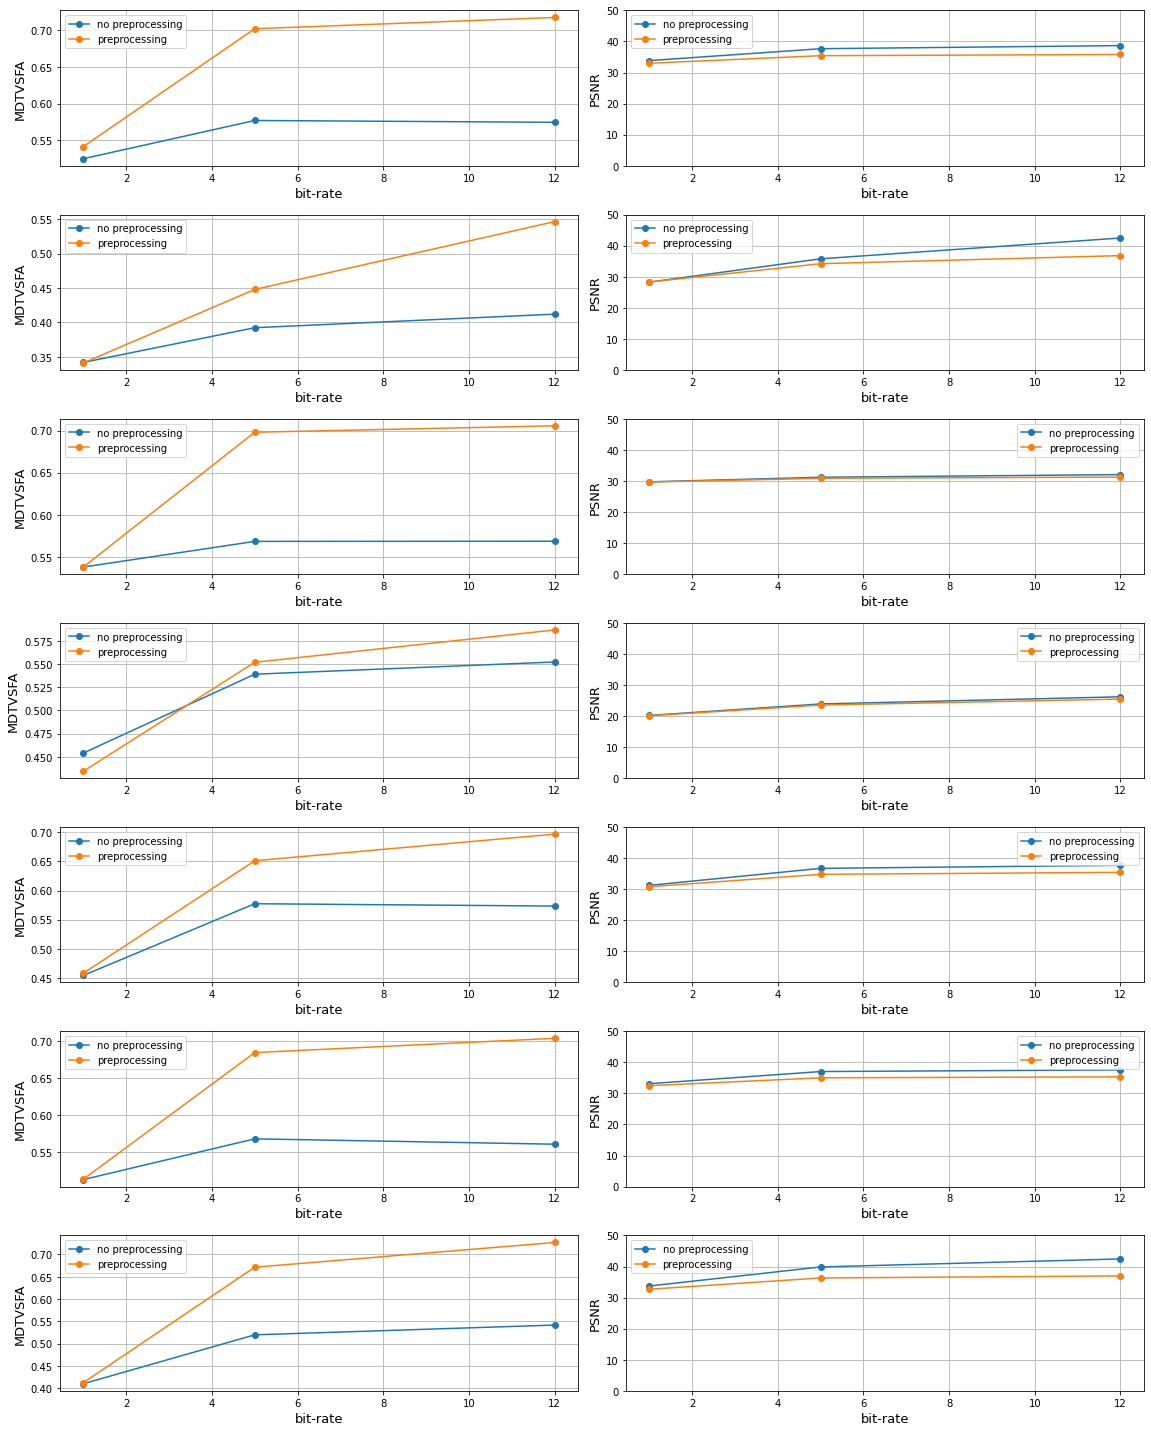

In [ ]:
fig, ax = plt.subplots(len(videos), 2, figsize=(16, 20))
for i in range(len(videos)):
  ax[i][0].plot(x, m_without[i], '-o', label = 'no preprocessing')
  ax[i][0].plot(x, m_with_preproc[i], '-o', label = 'preprocessing')
  ax[i][0].set_xlabel('bit-rate', fontsize=13)
  ax[i][0].set_ylabel('MDTVSFA', fontsize=13)
  ax[i][0].legend()
  ax[i][0].grid()

  ax[i][1].plot(x, psnr_without[i], '-o', label = 'no preprocessing')
  ax[i][1].plot(x, psnr_with_preproc[i], '-o', label = 'preprocessing')
  ax[i][1].set_xlabel('bit-rate', fontsize=13)
  ax[i][1].set_ylabel('PSNR', fontsize=13)
  ax[i][1].legend()
  ax[i][1].set_ylim([0, 50])
  ax[i][1].grid()

fig.patch.set_facecolor('white')
fig.tight_layout()